# Maximum Entropy Forecasting Pipeline

This notebook demonstrates the full pipeline:
1. Generate relevant variables for a forecasting question
2. Generate probability/expectation estimates using natural language format
3. Build a maximum entropy distribution from the estimates

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

# Check API key is set
assert os.getenv("OPENROUTER_API_KEY"), "Set OPENROUTER_API_KEY in .env file"

## Step 1: Set up the LLM client and generators

In [9]:
from calibrated_response.llm.openrouter import OpenRouterClient
from calibrated_response.generation.variable_generator import VariableGenerator
from calibrated_response.generation.natural_estimate_generator import NaturalEstimateGenerator

# Initialize the LLM client
llm = OpenRouterClient(
    model="openai/gpt-4o-mini",
    providers=["Google"],  # Route to Google for best Gemini performance
)

# Initialize generators
var_gen = VariableGenerator(llm)
est_gen = NaturalEstimateGenerator(llm)

## Step 2: Define the forecasting question

In [10]:
question = """What will be the average price of lithium-ion battery packs 
(in $/kWh) for electric vehicles in 2027?"""

print(f"Forecasting question: {question}")

Forecasting question: What will be the average price of lithium-ion battery packs 
(in $/kWh) for electric vehicles in 2027?


## Step 3: Generate relevant variables

In [11]:
# Generate variables that might influence the forecast
variables = var_gen.generate(question, n_variables=5)

print(f"Generated {len(variables)} variables:\n")
for v in variables:
    print(f"  - {v.name} ({v.type.value}): {v.description}")
    if hasattr(v, 'lower_bound') and hasattr(v, 'upper_bound'):
        unit = getattr(v, 'unit', '') or ''
        print(f"    Domain: [{v.lower_bound}, {v.upper_bound}] {unit}")

Generated 5 variables:

  - avg_battery_price_2027 (continuous): Projected average price of lithium-ion battery packs in 2027
    Domain: [100.0, 400.0] dollars/kWh
  - lithium_supply_chain_stability (binary): Stability of the lithium supply chain affecting prices
  - global_ev_sales_growth (continuous): Projected growth rate of global electric vehicle sales
    Domain: [5.0, 30.0] percent
  - battery_technology_advancements (continuous): Rate of advancements in battery technology
    Domain: [0.0, 5.0] years per generation
  - government_policy_support (binary): Level of government support for electric vehicles and batteries


## Step 4: Generate estimates using natural language format

In [12]:
# Generate estimates in natural language format
estimates = est_gen.generate(
    question=question,
    variables=variables,
    num_estimates=30,
)

print(f"Generated {len(estimates)} estimates:\n")
for est in estimates:
    print(f"  {est.to_query_estimate()}")

Generated 25 estimates:

  P(avg_battery_price_2027 < 200.0 | lithium_supply_chain_stability = True) = 0.7
  E[avg_battery_price_2027] = 250.0
  P(avg_battery_price_2027 > 300.0 | global_ev_sales_growth > 20.0) = 0.65
  E[avg_battery_price_2027 | government_policy_support = True] = 220.0
  P(avg_battery_price_2027 < 150.0 | battery_technology_advancements < 1.0) = 0.4
  P(avg_battery_price_2027 > 350.0 | lithium_supply_chain_stability = False) = 0.5
  E[avg_battery_price_2027] = 230.0
  P(avg_battery_price_2027 < 180.0 | government_policy_support = True) = 0.6
  E[avg_battery_price_2027 | global_ev_sales_growth < 10.0] = 280.0
  P(avg_battery_price_2027 < 200.0 | battery_technology_advancements < 2.0) = 0.5
  E[avg_battery_price_2027 | global_ev_sales_growth > 25.0] = 240.0
  P(avg_battery_price_2027 < 220.0 | lithium_supply_chain_stability = True) = 0.65
  E[avg_battery_price_2027 | battery_technology_advancements < 1.5] = 210.0
  P(avg_battery_price_2027 > 300.0 | global_ev_sales_gro

## Step 5: Build the maximum entropy distribution

In [ ]:
from calibrated_response.maxent.distribution_builder import DistributionBuilder
from calibrated_response.maxent.multivariate_solver import JAXSolverConfig

# Configure the solver
config = JAXSolverConfig(
    max_bins=20,      # Number of bins for discretization
    maxiter=500,    # Maximum optimization iterations
    tolerance=1e-6,         # Convergence tolerance
    constraint_weight=0.1,
)

# Build the distribution
builder = DistributionBuilder(
    variables=variables,
    estimates=estimates,
    solver_config=config,
)

print(f"Built constraints from {len(builder.constraints)} estimates")

Built constraints from 25 estimates


In [43]:
# Get the marginal distribution for the first continuous variable
# (typically the target variable)
from calibrated_response.models.variable import ContinuousVariable

target_var = next((v for v in variables if isinstance(v, ContinuousVariable)), variables[0])
print(f"Target variable: {target_var.name}")

distribution, info = builder.build(target_variable=target_var.name)

print(f"\nSolver info:")
for key, val in info.items():
    if key not in ['joint_distribution', 'bin_edges_list']:
        print(f"  {key}: {val}")

Target variable: avg_battery_price_2027

Solver info:
  n_iterations: 1
  final_loss: nan
  entropy: nan
  converged: False
  error: nan
  state: LbfgsState(iter_num=Array(1, dtype=int32, weak_type=True), value=Array(nan, dtype=float32), grad=Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32), stepsize=Array(0., dtype=float32), error=Array(nan, dtype=float32), s_history=Array([[nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32), y_history=Array([[nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32), rho_history=Array([nan, 

## Step 6: Visualize the distribution

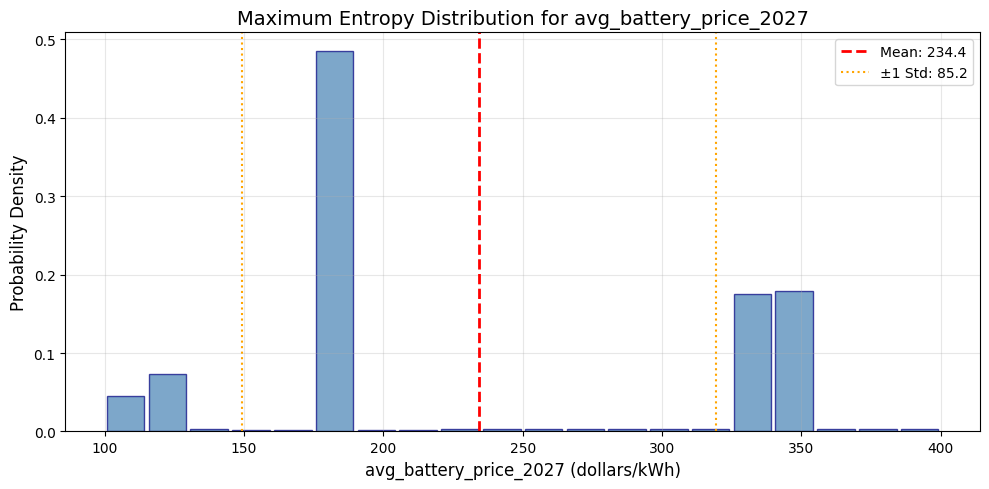


Statistics:
  Mean: 234.37
  Std Dev: 85.15
  90% CI: [94.29, 374.44]


In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the distribution
fig, ax = plt.subplots(figsize=(10, 5))

bin_edges = np.array(distribution.bin_edges)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = bin_edges[1:] - bin_edges[:-1]
probs = np.array(distribution.bin_probabilities)

ax.bar(bin_centers, probs, width=bin_widths * 0.9, alpha=0.7, color='steelblue', edgecolor='navy')
ax.set_xlabel(f"{target_var.name} ({getattr(target_var, 'unit', '')})", fontsize=12)
ax.set_ylabel('Probability Density', fontsize=12)
ax.set_title(f'Maximum Entropy Distribution for {target_var.name}', fontsize=14)
ax.grid(True, alpha=0.3)

# Add statistics
mean = np.sum(probs * bin_centers)
variance = np.sum(probs * (bin_centers - mean) ** 2)
std = np.sqrt(variance)

ax.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.1f}')
ax.axvline(mean - std, color='orange', linestyle=':', linewidth=1.5, label=f'±1 Std: {std:.1f}')
ax.axvline(mean + std, color='orange', linestyle=':', linewidth=1.5)
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nStatistics:")
print(f"  Mean: {mean:.2f}")
print(f"  Std Dev: {std:.2f}")
print(f"  90% CI: [{mean - 1.645*std:.2f}, {mean + 1.645*std:.2f}]")

## Step 7: Get all marginal distributions

In [ ]:
# Get marginal distributions for all variables
all_marginals = builder.get_all_marginals(info)

print(f"Computed marginals for {len(all_marginals)} variables:")
for var_name, dist in all_marginals.items():
    bin_centers = (np.array(dist.bin_edges[:-1]) + np.array(dist.bin_edges[1:])) / 2
    mean = np.sum(np.array(dist.bin_probabilities) * bin_centers)
    print(f"  {var_name}: mean = {mean:.2f}, bins = {len(dist.bin_edges)-1}")

Computed marginals for 5 variables:
  avg_battery_price_2027: mean = 234.37
  lithium_supply_chain_stability: mean = 0.27
  global_ev_sales_growth: mean = 12.97
  battery_technology_advancements: mean = 2.50
  government_policy_support: mean = 0.39


In [35]:
print(all_marginals)

{'avg_battery_price_2027': HistogramDistribution(bin_edges=[100.0, 115.0, 130.0, 145.0, 160.0, 175.0, 190.0, 205.0, 220.0, 235.0, 250.0, 265.0, 280.0, 295.0, 310.0, 325.0, 340.0, 355.0, 370.0, 385.0, 400.0], bin_probabilities=[0.04458816722035408, 0.07372293621301651, 0.0025664889253675938, 0.00248986529186368, 0.002397149335592985, 0.48462915420532227, 0.0024423771537840366, 0.0024302545934915543, 0.002498467918485403, 0.0025965659879148006, 0.002658213023096323, 0.0026677348650991917, 0.002865102142095566, 0.002897293772548437, 0.002884787507355213, 0.17578338086605072, 0.17959590256214142, 0.0034258924424648285, 0.00342496857047081, 0.0034355572424829006]), 'lithium_supply_chain_stability': HistogramDistribution(bin_edges=[0.0, 0.5, 1.0], bin_probabilities=[0.9649866819381714, 0.0350135900080204]), 'global_ev_sales_growth': HistogramDistribution(bin_edges=[5.0, 6.25, 7.5, 8.75, 10.0, 11.25, 12.5, 13.75, 15.0, 16.25, 17.5, 18.75, 20.0, 21.25, 22.5, 23.75, 25.0, 26.25, 27.5, 28.75, 30

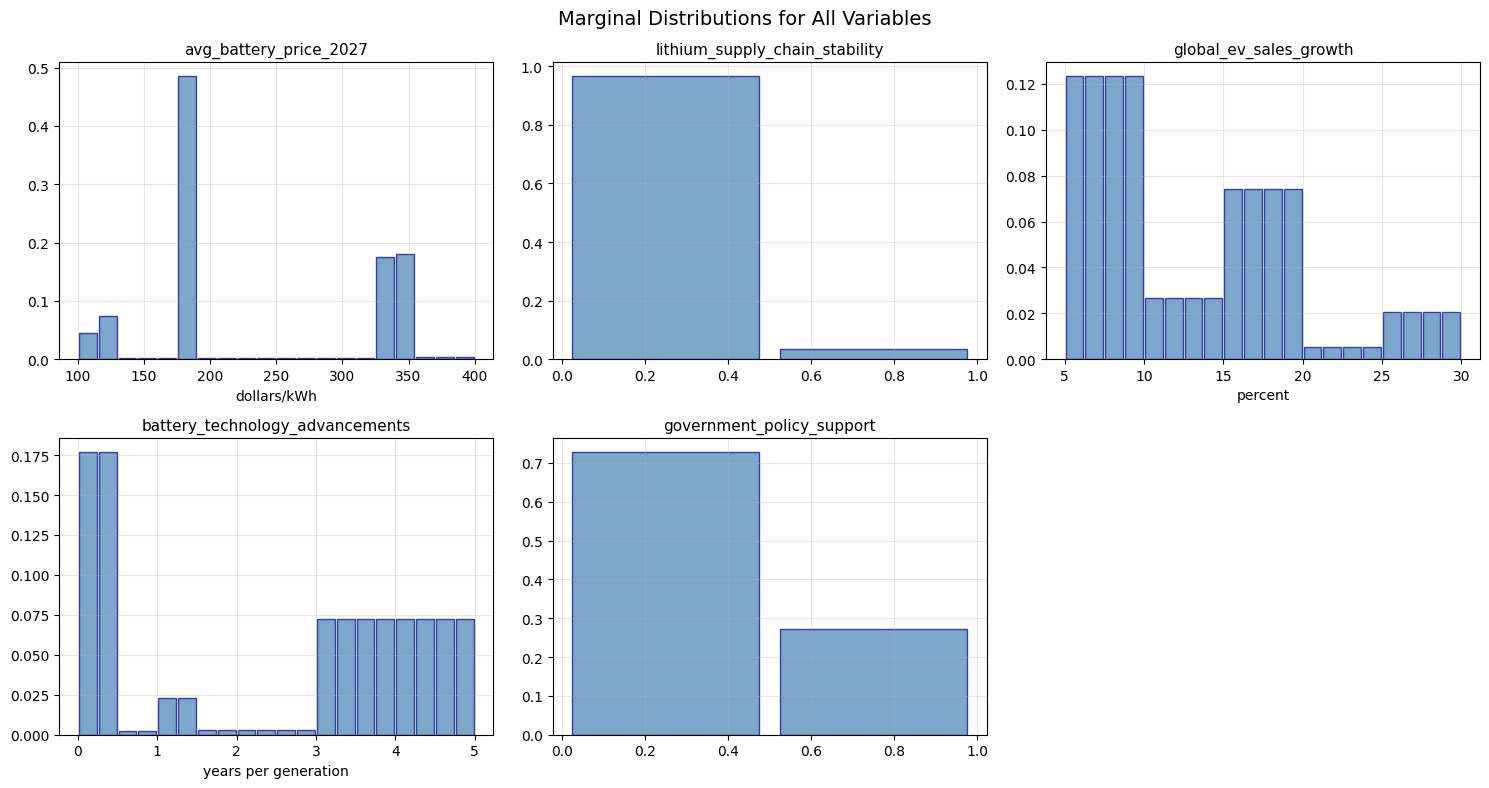

In [34]:
# Plot all marginals in a grid
n_vars = len(variables)
n_cols = min(3, n_vars)
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_vars == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, var in enumerate(variables):
    ax = axes[idx]
    dist = all_marginals[var.name]
    
    bin_edges = np.array(dist.bin_edges)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    probs = np.array(dist.bin_probabilities)
    
    ax.bar(bin_centers, probs, width=bin_widths * 0.9, alpha=0.7, color='steelblue', edgecolor='navy')
    ax.set_title(var.name, fontsize=11)
    ax.set_xlabel(getattr(var, 'unit', '') or '', fontsize=10)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_vars, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Marginal Distributions for All Variables', fontsize=14)
plt.tight_layout()
plt.show()

## Step 8: Pairwise Marginal Plot

Visualize the relationships between all pairs of variables using a lower triangular plot.
- **Diagonal**: 1D marginal distributions with mean indicator
- **Lower triangle**: 2D joint marginal heatmaps
- **Upper triangle**: Empty (symmetric information)

The target variable is placed in the first row/column for easy comparison.

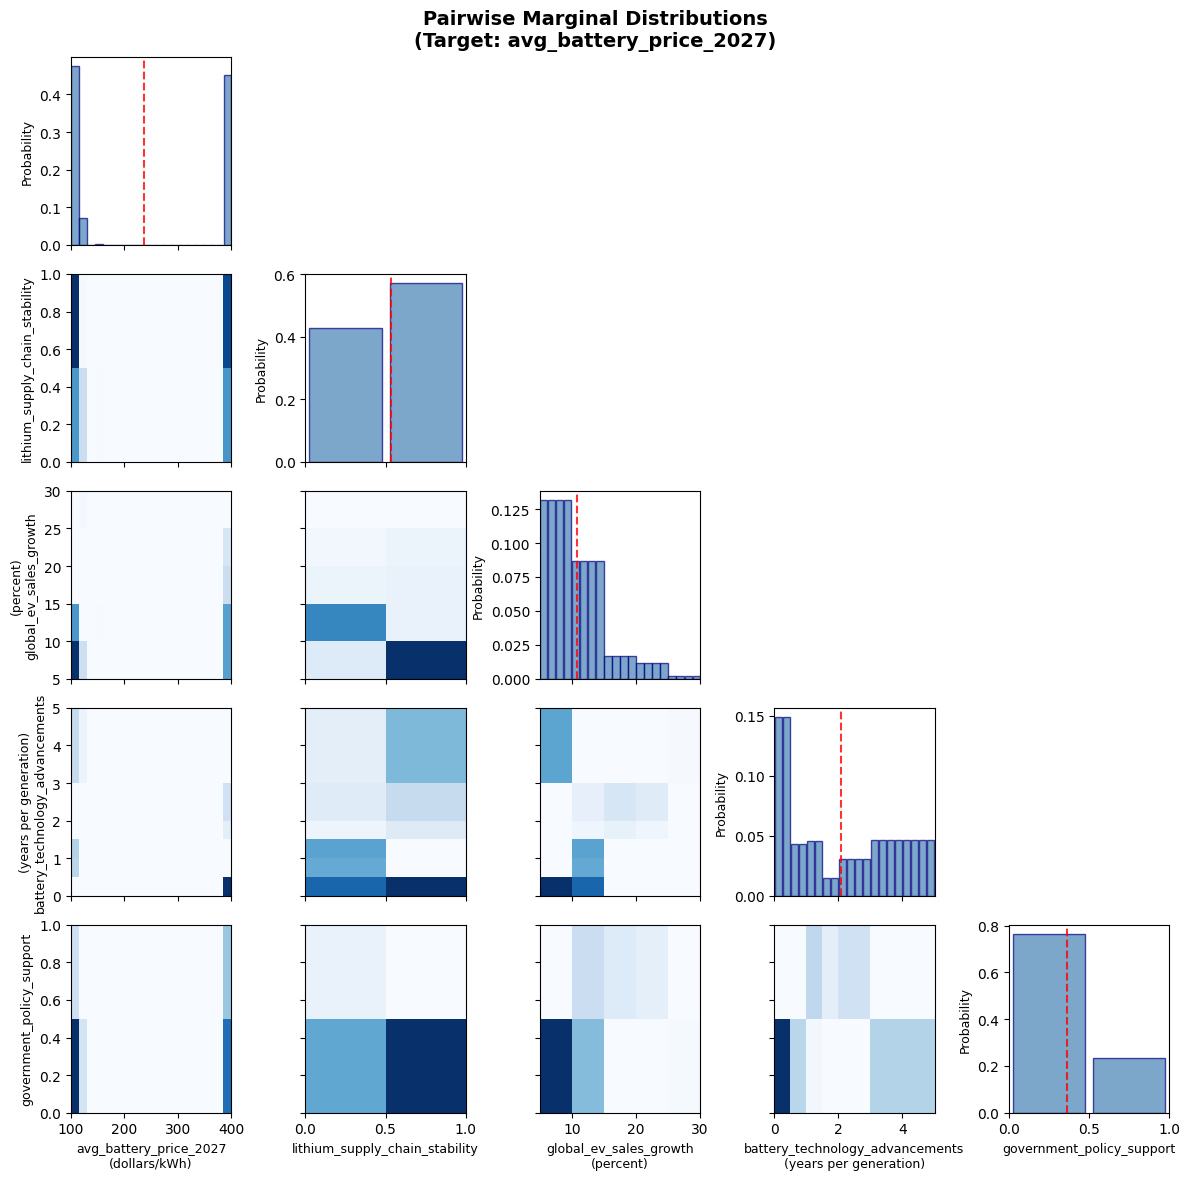

In [29]:
from calibrated_response.visualization.pairplot import plot_pairwise_marginals

# Get the joint distribution and bin edges from the last build
joint_dist = info['joint_distribution']
bin_edges = info['bin_edges_list']

# Create the pairwise plot
fig = plot_pairwise_marginals(
    joint_distribution=joint_dist,
    bin_edges_list=bin_edges,
    variables=variables,
    target_variable=target_var.name,
    constraints=builder.constraints,
    figsize=(12, 12),
    cmap='Blues',
)

plt.show()